In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install gym-anytrading

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import gym
import gym_anytrading

In [5]:
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
custom_env = gym.make('stocks-v0',
               df = STOCKS_GOOGL,
               window_size = 10,
               frame_bound = (10, 300))

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
print()
print("custom_env information:")
print("> shape:", custom_env.shape)
print("> df.shape:", custom_env.df.shape)
print("> prices.shape:", custom_env.prices.shape)
print("> signal_features.shape:", custom_env.signal_features.shape)
print("> max_possible_profit:", custom_env.max_possible_profit())


custom_env information:
> shape: (10, 2)
> df.shape: (2335, 6)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 5.19197248193094


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the envir

info: {'total_reward': 30.85589400000009, 'total_profit': 0.37890658748473305, 'position': 0}


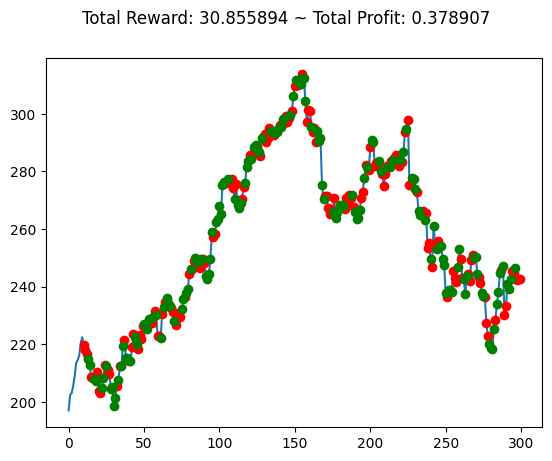

In [7]:
import matplotlib.pyplot as plt

env = custom_env
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

# Importing necessary Libraries

In [8]:
import random
import itertools
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import seaborn as sns
import tqdm

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Collection and Preprocessing

We collect the data on the Nifty50 index from January 1, 2010 to December 31, 2020.

In [10]:
nifty50 = yf.Ticker('^NSEI')

hist = nifty50.history(start='2010-1-1', end='2020-12-31')

hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00+05:30,5200.899902,5238.450195,5167.100098,5232.200195,0,0.0,0.0
2010-01-05 00:00:00+05:30,5277.149902,5288.350098,5242.399902,5277.899902,0,0.0,0.0
2010-01-06 00:00:00+05:30,5278.149902,5310.850098,5260.049805,5281.799805,0,0.0,0.0
2010-01-07 00:00:00+05:30,5281.799805,5302.549805,5244.750000,5263.100098,0,0.0,0.0
2010-01-08 00:00:00+05:30,5264.250000,5276.750000,5234.700195,5244.750000,0,0.0,0.0
...,...,...,...,...,...,...,...
2020-12-23 00:00:00+05:30,13473.500000,13619.450195,13432.200195,13601.099609,458700,0.0,0.0
2020-12-24 00:00:00+05:30,13672.150391,13771.750000,13626.900391,13749.250000,471400,0.0,0.0
2020-12-28 00:00:00+05:30,13815.150391,13885.299805,13811.549805,13873.200195,403600,0.0,0.0


In [11]:
hist.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

In [12]:
env = gym.make('stocks-v0', df=hist, window_size=1)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (1, 2)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the envir

[[4914.     58.25]]
info: {'total_reward': 2915.2451171875, 'total_profit': 0.0002977390650759599, 'position': 0}


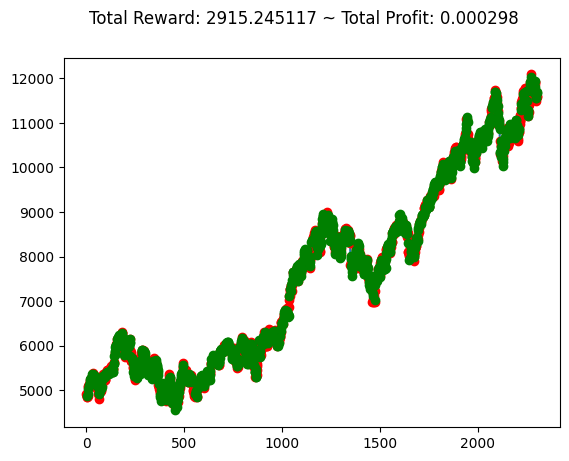

-65.69921875
[[11596.90039062   -90.59960938]]


In [13]:
observation = env.reset()
print(observation)
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()
print(reward)
print(observation)

In [14]:
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())

env information:
> shape: (1, 2)
> df.shape: (2692, 7)
> prices.shape: (2306,)
> signal_features.shape: (2306, 2)
> max_possible_profit: 6729.771423044508


We now preprocess the data to add in a column for daily return which the agent will check when making decisions on whether to buy, sell or hold the stock. We also normalize the daily return to cater for the variance in this data.

In [15]:
# Compute daily returns
daily_return = (hist.apply(lambda row: (row['Close'] - row['Open']) / row['Open'], axis=1))

# Normalize the daily return
normalized_daily_return = list(daily_return.map(lambda val: (val - min(daily_return)) / max(daily_return) - min(daily_return)))

# Add a column to the history dataframe
hist['Normalized Daily Return'] = normalized_daily_return

In [16]:
hist.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Normalized Daily Return
Date,,,,,,,,
2010-01-04 00:00:00+05:30,5200.899902,5238.450195,5167.100098,5232.200195,0,0.0,0.0,0.865451
2010-01-05 00:00:00+05:30,5277.149902,5288.350098,5242.399902,5277.899902,0,0.0,0.0,0.802312
2010-01-06 00:00:00+05:30,5278.149902,5310.850098,5260.049805,5281.799805,0,0.0,0.0,0.808215
2010-01-07 00:00:00+05:30,5281.799805,5302.549805,5244.750000,5263.100098,0,0.0,0.0,0.762742
2010-01-08 00:00:00+05:30,5264.250000,5276.750000,5234.700195,5244.750000,0,0.0,0.0,0.760982


In [17]:
hist.iloc[0,0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5200.89990234375

In [18]:
len(hist)

2692

# Implementing Reinforcement Learning Algorithms

We decided to use the Q Learning algorithm that the paper describes but in addition we attempt to compare the algorithm to other algorithms (TBD)

The shape of our state is (4,). The features will include the opening price of the nifty50 index, the amount of money the agent has available, the number of stocks the agent owns, the profit the agent has made (negative if agent is at a loss), the normalized daily return of the stock

A reward is issued equivalent to the amount of value buying or selling a stock will earn for the agent, ie. wealthAfterTrade - wealthBeforeTrade

An action can be one of buy, sell or hold

## Tensorflow attempt

In [20]:
REPLAY_MEMORY_SIZE = 2500
MIN_REPLAY_MEMORY_SIZE = 250
MINIBATCH_SIZE = 64
UPDATE_TARGET_EVERY = 1
DISCOUNT = .99
EPISODES = 10
AGGREGATE_STATS_EVERY = 1
class DQNAgent:
  def __init__(self):
    # main model -> gets trained every step
    self.model = self.create_model()

    # target model -> predicts the actions
    ## we split the models to have some stability since at each step we train and predict
    self.target_model = self.create_model()
    self.target_model.set_weights(self.model.get_weights())

    self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

    self.target_update_counter = 0
  
  def create_model(self):
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(2,)))
    model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

    model.compile(optimizer=Adam(0.001), 
                  loss='mse',
                  metrics=['accuracy']
                  )
    return model


  def update_replay_memory(self, transition):
    # transition is our (s, a, r, s') pair
    self.replay_memory.append(transition)

  def get_qs(self, state):
    return self.model.predict(state, verbose = 0)[0]

  def train(self, terminal_state):
    # start training only if certain number of sampels is already saved
    if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
      return
    
    # obtain a minibatch from which to train
    minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

    # obtain current states from the minibatch
    crs = list(transition[0] for transition in minibatch)
    current_states = np.array(crs)
    #print(current_states[0])
    #print(current_states.shape)
    # obtain q values for the state
    current_q_vals = self.model.predict(current_states.reshape((current_states.shape[0], 2)), verbose = 0)

    # get next states
    ns = list(transition[3] for transition in minibatch)
    next_states = np.array(ns)
    #print(next_states[0])
    #print(next_states.shape)
    # obtain q values for the next state
    next_q_vals = self.target_model.predict(next_states.reshape((next_states.shape[0], 2)), verbose = 0)

    # we now update the model
    x = list()
    y = list()

    for index, (cur_state, action, reward, next_state, done) in enumerate(minibatch):
      if not done:
        max_next_q = np.argmax(next_q_vals)
        new_q = reward + DISCOUNT * max_next_q

      else:
        new_q = reward

      # update q value for the given state
      current_qs = current_q_vals[index]
      current_qs[action] = new_q

      # and append to the training data
      x.append(cur_state)
      y.append(current_qs)

    # fit on all samples as one batch
    x = np.array(x)
    x = x.reshape((x.shape[0], 2))
    y = np.array(y)
    #print(x.shape, y.shape)
    self.model.fit(np.array(x), np.array(y), verbose=0, shuffle=False)

    # update the update counter every episode
    if terminal_state:
      self.target_update_counter += 1

    # update the target weights if we have reached threshold
    if self.target_update_counter > UPDATE_TARGET_EVERY:
      self.target_model.set_weights(self.model.get_weights())
      self.target_update_counter = 0 # reset the update counter

  0%|          | 0/10 [00:00<?, ?it/s]

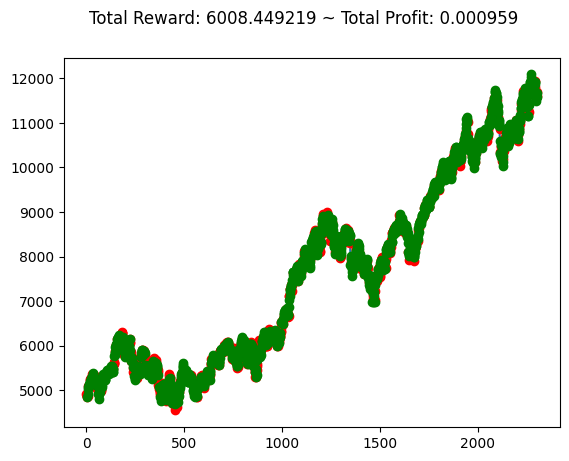

 10%|█         | 1/10 [06:15<56:22, 375.80s/it]

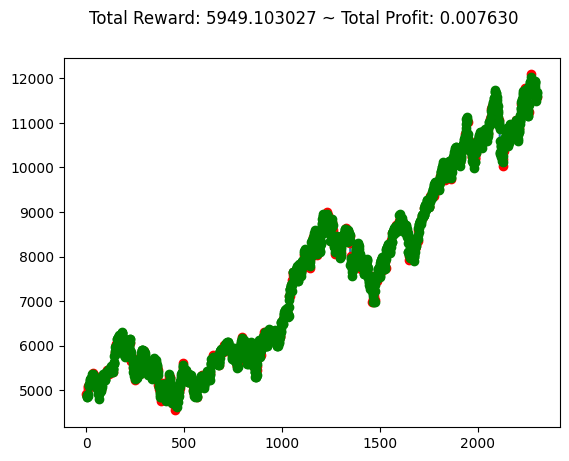

 20%|██        | 2/10 [13:11<53:15, 399.47s/it]

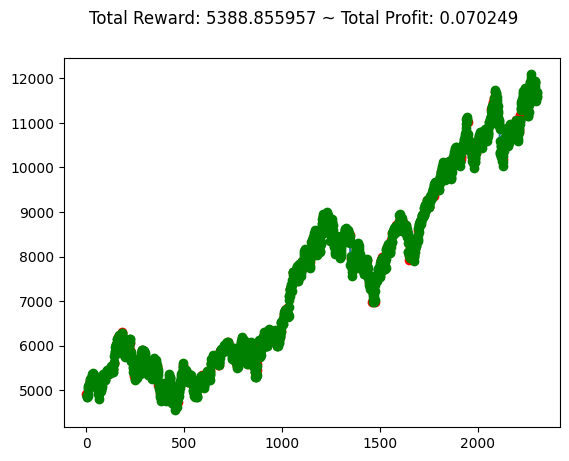

 30%|███       | 3/10 [20:26<48:29, 415.71s/it]

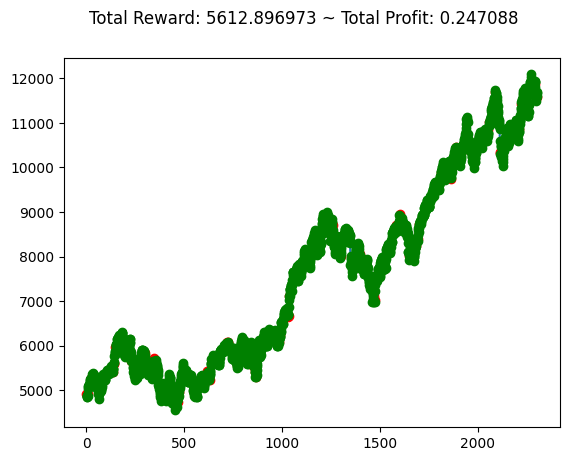

 40%|████      | 4/10 [27:55<42:51, 428.66s/it]

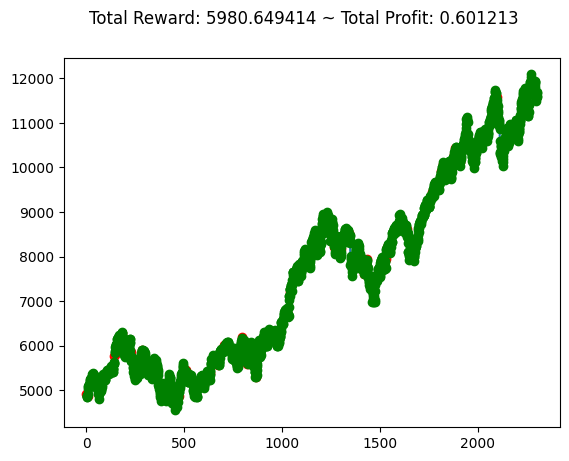

 50%|█████     | 5/10 [35:29<36:30, 438.01s/it]

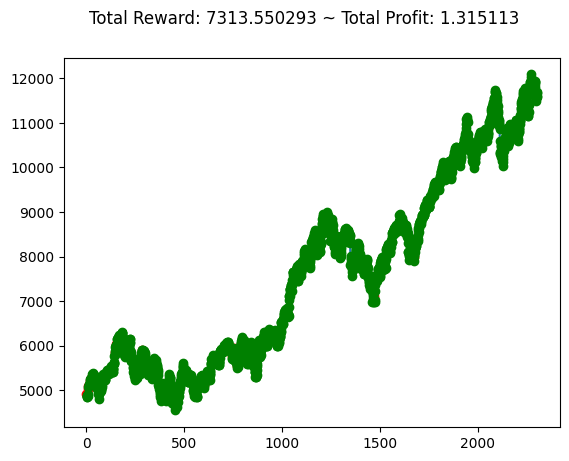

 60%|██████    | 6/10 [43:07<29:38, 444.59s/it]

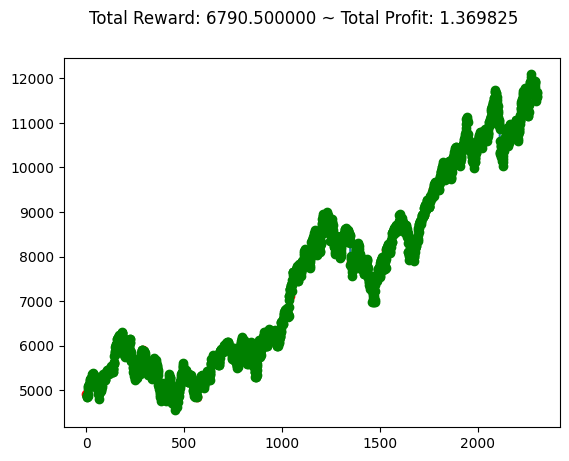

 70%|███████   | 7/10 [50:45<22:26, 448.90s/it]

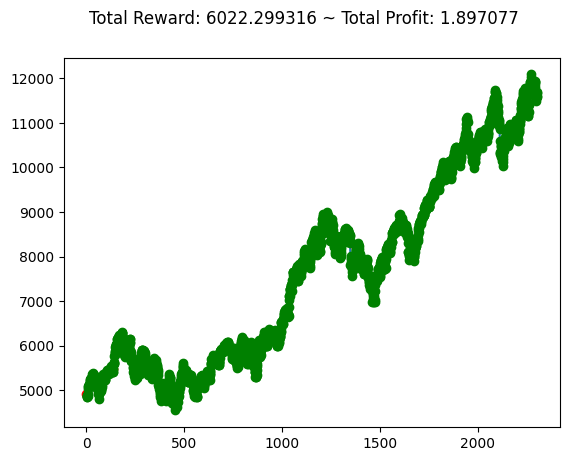

 80%|████████  | 8/10 [58:26<15:05, 452.88s/it]

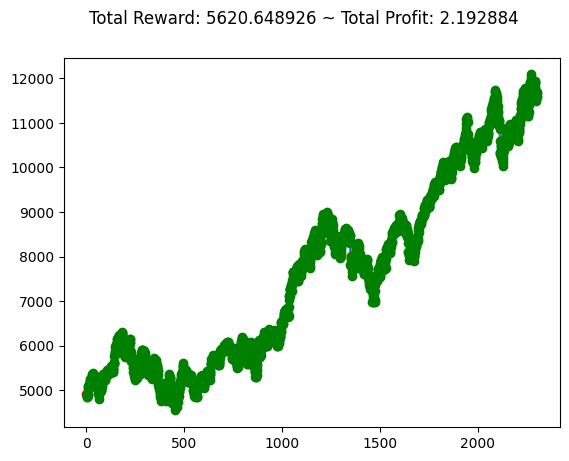

 90%|█████████ | 9/10 [1:06:09<07:36, 456.16s/it]

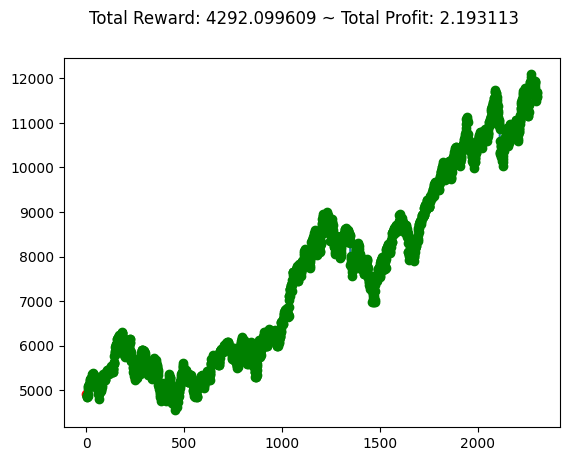

100%|██████████| 10/10 [1:13:53<00:00, 443.30s/it]


In [21]:
agent = DQNAgent()
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001
ep_rewards = []

for episode in tqdm.trange(EPISODES):
    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        #print(current_state)
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, 2)

        new_state, reward, done, _ = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done)

        current_state = new_state
        step += 1 
        # Append episode reward to a list and log stats (every given number of episodes)

            # Save model, but only when min reward is greater or equal a set value
            # 
        # Decay epsilon
        if epsilon > MIN_EPSILON:
            epsilon *= EPSILON_DECAY
            epsilon = max(MIN_EPSILON, epsilon)
        
    plt.cla()
    env.render_all()
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


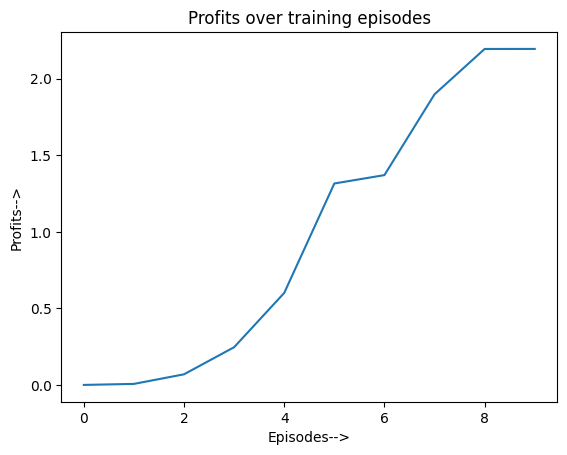

In [32]:
profit = [0.000959, 0.007630, 0.070249, 0.247088, 0.601213, 1.315115, 1.369825, 1.897077, 2.192884, 2.193113]
plt.title('Profits over training episodes')
plt.xlabel('Episodes-->')
plt.ylabel('Profits-->')
plt.plot(profit)

In [22]:
test_env = gym.make('stocks-v0',
               df = STOCKS_GOOGL,
               window_size = 1)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (1, 2)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


info: {'total_reward': 394.9636889999997, 'total_profit': 0.0005439799503416715, 'position': 1}


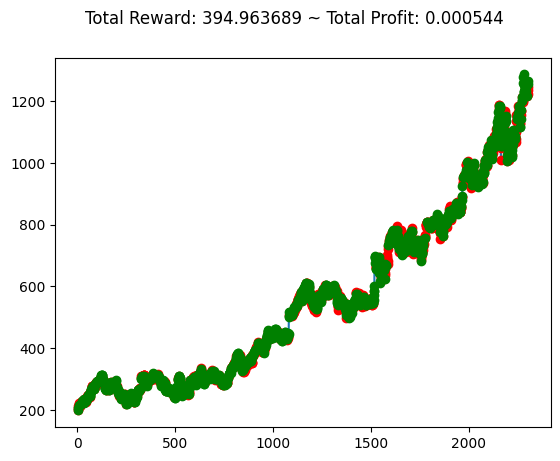

In [25]:
observation = test_env.reset()
while True:
    action = test_env.action_space.sample()
    observation, reward, done, info = test_env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
test_env.render_all()
plt.show()

In [27]:
print("env information:")
print("> shape:", test_env.shape)
print("> df.shape:", test_env.df.shape)
print("> prices.shape:", test_env.prices.shape)
print("> signal_features.shape:", test_env.signal_features.shape)
print("> max_possible_profit:", test_env.max_possible_profit())

env information:
> shape: (1, 2)
> df.shape: (2335, 6)
> prices.shape: (2306,)
> signal_features.shape: (2306, 2)
> max_possible_profit: 324533.23901761015


  0%|          | 0/1 [00:00<?, ?it/s]

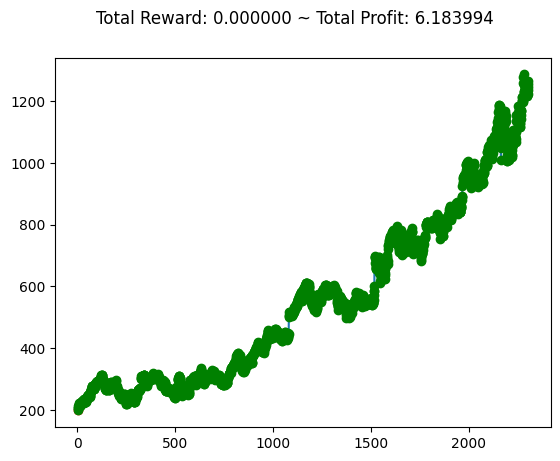

100%|██████████| 1/1 [01:54<00:00, 114.75s/it]


In [28]:
for episode in tqdm.trange(1):
    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = test_env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        #print(current_state)
        # Get action from Q table
        action = np.argmax(agent.get_qs(current_state))

        new_state, reward, done, _ = test_env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        # Every step we update replay memory and train main network
        #agent.update_replay_memory((current_state, action, reward, new_state, done))
        #agent.train(done)

        current_state = new_state
        step += 1 
        # Append episode reward to a list and log stats (every given number of episodes)

            # Save model, but only when min reward is greater or equal a set value
            # 
        # Decay epsilon
        # if epsilon > MIN_EPSILON:
        #     epsilon *= EPSILON_DECAY
        #     epsilon = max(MIN_EPSILON, epsilon)
        
    plt.cla()
    test_env.render_all()
    plt.show()